# Linear thermoelasticity (weak coupling)


## Problem position

We consider the case of a rectangular 2D domain of dimensions $L\times H$ fully clamped on both lateral sides and subjected to a self-weight loading. The top side is subjected to a uniform temperature increase of $\Delta T = +20^{\circ}C$ while the bottom and lateral boundaries remain at the initial temperature $T_0$. The geometry and boundary regions are first defined.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
import ufl
from dolfinx import fem, mesh, io, plot
import dolfinx.fem.petsc
import pyvista


L, H = 5, 0.3
Nx, Ny = 20, 5
domain = mesh.create_rectangle(
    MPI.COMM_WORLD,
    [(0.0, 0.0), (L, H)],
    [Nx, Ny],
    cell_type=mesh.CellType.quadrilateral,
)
gdim = domain.geometry.dim

def lateral_sides(x):
    return np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], L))

def bottom(x):
    return np.isclose(x[1], 0.0)

def top(x):
    return np.isclose(x[1], H)

In [2]:
type(lateral_sides)

function

In [3]:
VT = fem.functionspace(domain, ("Q", 1))              #define the finite element function space

T_, dT = ufl.TestFunction(VT), ufl.TrialFunction(VT)  # T_ is the test function, like v

Delta_T = fem.Function(VT, name="Temperature_variation")

aT = ufl.dot(ufl.grad(dT), ufl.grad(T_)) * ufl.dx     # a is grad T, grad T_, like grad u, grad v

LT = fem.Constant(domain, 0.0) * T_ * ufl.dx          # L is 0, o*v, v is T_

bot_dofs_T = fem.locate_dofs_geometrical(VT, bottom)
top_dofs_T = fem.locate_dofs_geometrical(VT, top)
sides_dofs_T = fem.locate_dofs_geometrical(VT, lateral_sides)
bcT = [
    fem.dirichletbc(20.0, bot_dofs_T, VT),
    fem.dirichletbc(20.0, top_dofs_T, VT),
    fem.dirichletbc(20.0, sides_dofs_T, VT),
]

# solve problem
problem = fem.petsc.LinearProblem(aT, LT, u=Delta_T, bcs=bcT)
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, [])), 0)

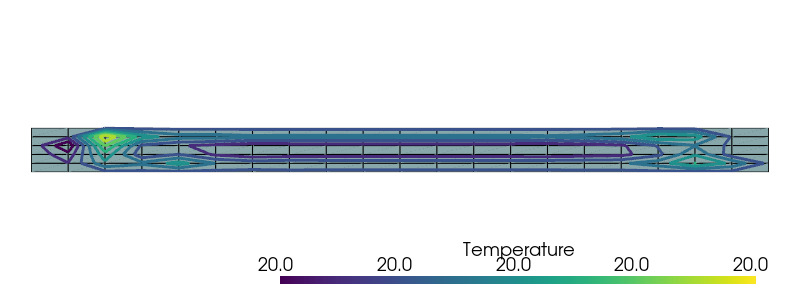

In [4]:
pyvista.set_jupyter_backend("static")

topology, cell_types, geometry = plot.vtk_mesh(domain, gdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

T_topology, T_cell_types, T_geometry = plot.vtk_mesh(VT)
T_grid = pyvista.UnstructuredGrid(T_topology, T_cell_types, T_geometry)
T_grid.point_data["Temperature"] = Delta_T.x.array
T_grid.set_active_scalars("Temperature")
contours = T_grid.contour()

plotter = pyvista.Plotter()
plotter.window_size = (800, 300)
plotter.add_mesh(grid, show_edges=True)
plotter.add_mesh(contours, line_width=3)
plotter.view_xy()
plotter.zoom_camera(2.5)
plotter.show()

In [5]:
print(Delta_T.x.array)

[19.9999975  19.9999975  19.9999975  19.99999062 19.9999975  19.99998397
 19.9999975  20.00001769 19.9999975  19.99997074 20.00002591 19.9999975
 20.00001197 19.9999975  19.99999323 20.00004021 19.99999301 19.9999975
 20.00002379 19.9999975  19.9999975  20.00005874 19.99999817 20.00000043
 19.9999975  20.00000963 19.9999975  20.00002447 19.99999135 19.99998856
 19.9999975  20.00000634 19.9999975  20.00001416 19.99998743 19.99998337
 19.9999975  20.00000774 19.9999975  20.00001414 19.99998346 19.99998491
 19.9999975  20.00000746 19.9999975  20.00001196 19.99998413 19.99998471
 19.9999975  20.00000749 19.9999975  20.00001218 19.99998415 19.9999847
 19.9999975  20.00000749 19.9999975  20.00001224 19.99998411 19.99998471
 19.9999975  20.00000749 19.9999975  20.00001221 19.99998413 19.9999847
 19.9999975  20.00000751 19.9999975  20.00001222 19.99998411 19.99998474
 19.9999975  20.00000746 19.9999975  20.00001221 19.99998415 19.99998468
 19.9999975  20.00000743 19.9999975  20.00001221 19.999

In [6]:
for i in range(len(Delta_T.x.array)):
    Delta_T.x.array[i] = 20
print(Delta_T.x.array)

[20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]


In [17]:
Delta_T = ufl.grad(Delta_T)


<bound method Grad.evaluate of Grad(Grad(Grad(Grad(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, [])), 0)))))>
None


## Mechanical problem

The linearized thermoelastic constitutive equation is given by:

$$
\boldsymbol{\sigma} = \mathbb{C}:(\boldsymbol{\varepsilon}-\alpha(T-T_0)\boldsymbol{1}) = \lambda\text{tr}(\boldsymbol{\varepsilon})\boldsymbol{1}+2\mu\boldsymbol{\varepsilon} -\alpha(3\lambda+2\mu)(T-T_0)\boldsymbol{1}
$$

where $\lambda,\mu$ are the Lamé parameters and $\alpha$ is the thermal expansion coefficient. As regards the current problem, the last term corresponding to the thermal strains is completely known. The following formulation can thus be generalized to any kind of known initial stress or eigenstrain state such as pre-stress or phase changes.

In [13]:
Delta_T = ufl.grad(Delta_T)
E = fem.Constant(domain, 50e3)             # Elastic module
nu = fem.Constant(domain, 0.2)             # Poission ratio

mu = E / 2 / (1 + nu)                      # Shear modulus
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)   # Lame parameters
alpha = fem.Constant(domain, 1e-5)         # Thermal expansion coefficient

f = fem.Constant(domain, (0.0, 0.0))       # O for external force

def eps(v):                                # epsilon, strain, the deforamtion, dy/y 
    return ufl.sym(ufl.grad(v))

def sigma(v, Delta_T):                     # sigmathis is sigma
    return (lmbda * ufl.tr(eps(v)) - alpha * (3 * lmbda + 2 * mu) *Delta_T
    ) * ufl.Identity(gdim)  + 2.0 * mu * eps(v)     # here braces is important, can not be in above line

Vu = fem.functionspace(domain, ("Q", 2, (gdim,))) 
du = ufl.TrialFunction(Vu)
u_ = ufl.TestFunction(Vu)

Wint = ufl.inner(sigma(du, Delta_T), eps(u_)) * ufl.dx  # here du is unkown
aM = ufl.lhs(Wint)                                      # Wint is long and lhs can help to distinguish unkown and know.
LM = ufl.rhs(Wint) + ufl.inner(f, u_) * ufl.dx          # knows parameters are in lhs

lateral_dofs_u = fem.locate_dofs_geometrical(Vu, lateral_sides) # lateral sides of domain
bcu = [fem.dirichletbc(np.zeros((gdim,)), lateral_dofs_u, Vu)]  # displacement Vu is fixed in lateral sides

ValueError: Can't add expressions with different shapes.

First, the self-weight loading is deactivated, only thermal stresses are computed.

In [8]:
u = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u, bcs=bcu)
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 0), blocked element (Basix element (P, quadrilateral, 2, gll_warped, unset, False, float64, []), (2,))), 1)

The deformed shape under thermal expansion is plotted using `pyvista`:

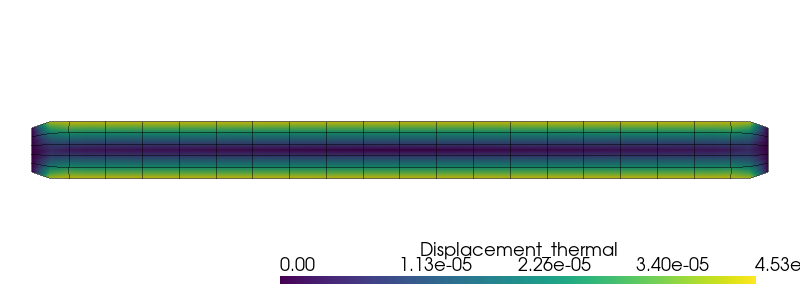

In [9]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vu)                # get mesh data
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry) # plot grid
u_3D = np.zeros((u_geometry.shape[0], 3))
u_3D[:, :2] = u.x.array.reshape(-1, 2)
u_grid.point_data["Displacement_thermal"] = u_3D
u_grid.set_active_vectors("Displacement_thermal")
warped = u_grid.warp_by_vector("Displacement_thermal", factor=1000)

plotter = pyvista.Plotter()
plotter.window_size = (800, 300)
plotter.add_mesh(warped)
edges = warped.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1, opacity=0.5)
plotter.view_xy()
plotter.zoom_camera(2.5)
plotter.show()

We now take into account the self-weight.

In [10]:
rho_g = 2400 * 9.81e-6
f.value[1] = -rho_g
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 0), blocked element (Basix element (P, quadrilateral, 2, gll_warped, unset, False, float64, []), (2,))), 1)

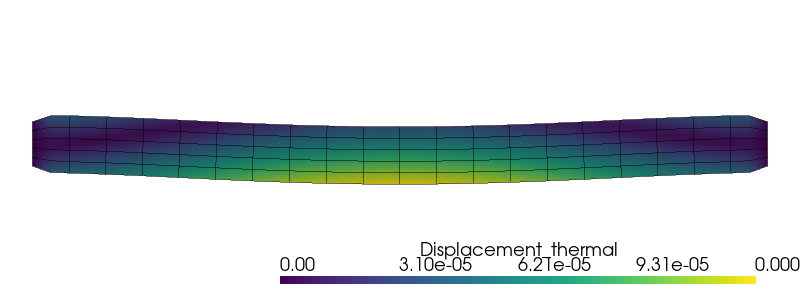

In [11]:
u_3D[:, :2] = u.x.array.reshape(-1, 2)
u_grid.point_data["Displacement_weight"] = u_3D
u_grid.set_active_vectors("Displacement_weight")

warped = u_grid.warp_by_vector("Displacement_weight", factor=1000)

plotter = pyvista.Plotter()
plotter.window_size = (800, 300)
plotter.add_mesh(warped)
edges = warped.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1, opacity=0.5)
plotter.view_xy()
plotter.zoom_camera(2.5)
plotter.show()